In [1]:
!python -V

Python 3.12.1


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-duration-experiment")

2025/02/11 10:05:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/02/11 10:05:45 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops/02/experiment_tracking/mlruns/1', creation_time=1739268346320, experiment_id='1', last_update_time=1739268346320, lifecycle_stage='active', name='nyc-duration-experiment', tags={}>

In [8]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_14214/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_14214/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


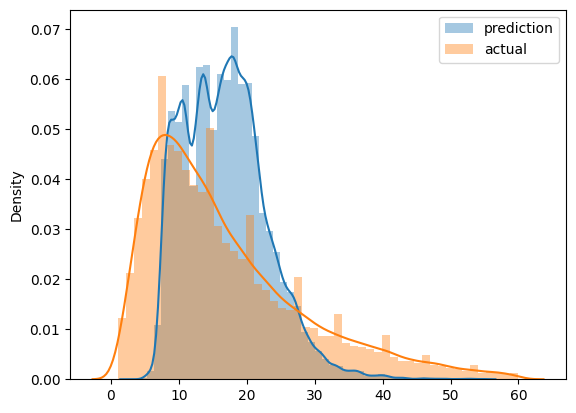

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():
    mlflow.set_tag("developer", "luca")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "/data/green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [23]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [32]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("developer", "luca")
        mlflow.set_tag("model", "xgboost")
    
        mlflow.log_params(params)
    
        booster = xgb.train(params=params, dtrain=train,num_boost_round=1000,evals=[(valid, "validation")], early_stopping_rounds=50)
    
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(fn=objective, space=search_space,algo=tpe.suggest,max_evals=5,trials=Trials())

  0%|                                                                                                                                 | 0/5 [00:00<?, ?trial/s, best loss=?]

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:45:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.90762                                                                                                                                                 
[1]	validation-rmse:6.89328                                                                                                                                                 
[2]	validation-rmse:6.65089                                                                                                                                                 
[3]	validation-rmse:6.56840                                                                                                                                                 
[4]	validation-rmse:6.53865                                                                                                                                                 
[5]	validation-rmse:6.53115                                                                                                            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:45:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34167                                                                                                                                                 
[1]	validation-rmse:6.67213                                                                                                                                                 
[2]	validation-rmse:6.55130                                                                                                                                                 
[3]	validation-rmse:6.51339                                                                                                                                                 
[4]	validation-rmse:6.50798                                                                                                                                                 
[5]	validation-rmse:6.49817                                                                                                            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:46:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46082                                                                                                                                                
[1]	validation-rmse:10.80266                                                                                                                                                
[2]	validation-rmse:10.22369                                                                                                                                                
[3]	validation-rmse:9.71659                                                                                                                                                 
[4]	validation-rmse:9.28178                                                                                                                                                 
[5]	validation-rmse:8.90285                                                                                                            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:51:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.06738                                                                                                                                                
[1]	validation-rmse:10.13846                                                                                                                                                
[2]	validation-rmse:9.39038                                                                                                                                                 
[3]	validation-rmse:8.79604                                                                                                                                                 
[4]	validation-rmse:8.31793                                                                                                                                                 
[5]	validation-rmse:7.94333                                                                                                            

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:55:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94500                                                                                                                                                 
[1]	validation-rmse:7.56646                                                                                                                                                 
[2]	validation-rmse:7.02445                                                                                                                                                 
[3]	validation-rmse:6.81037                                                                                                                                                 
[4]	validation-rmse:6.71233                                                                                                                                                 
[5]	validation-rmse:6.66012                                                                                                            